### The model

$u(c) = log(c+1)$ utility function    
$y = 1$ Deterministic income    
$p(r = 0.02) = 0.5$   
$p(r = -0.01) = 0.5$ 

In [1]:
# infinite horizon MDP problem
%pylab inline
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")

# discounting factor 
beta = 0.95
# wealth level
eps = 0.001
w_low = eps
w_high = 10
# interest rate
r_up = 0.02
r_down = 0.01
# deterministic income
y = 1
# good state and bad state economy with equal probability 0.5
# with good investment return 0.02 or bad investment return -0.01
ws = np.linspace(w_low, w_high**(0.5),100)**2
Vs = np.zeros(100)
Cs = np.zeros(100)

def u(c):
    return np.log(c)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Value iteration
for j in range(30):
    if j % 10 == 0:
        print(j)
    for i in range(len(ws)):
        w = ws[i]
        def obj(c):
            return -(u(c) + beta*(np.interp((y+w-c)*(1+r_up), ws, Vs) + np.interp((y+w-c)*(1-r_down), ws, Vs))/2)
        bounds = [(eps, y+w-eps)]
        res = minimize(obj, eps, method='SLSQP', bounds=bounds)
        Cs[i] = res.x[0]
        Vs[i] = -res.fun

0
10
20


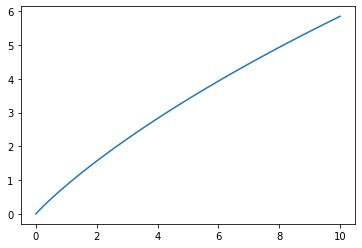

In [3]:
plt.plot(ws,Vs)

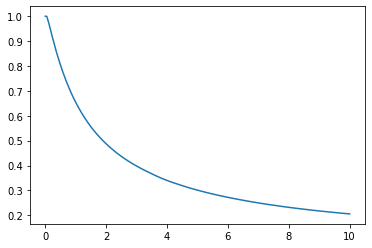

In [8]:
plt.plot(ws,Cs/(ws+y))

### policy gradient
Assume the policy form $\theta = (a,b,c, \sigma = 0.1)$, then $\pi_\theta$ ~ $N(\frac{1}{1+e^{a w^2 +b w + c}}, \sigma)$

Assume the initial value $a = 1$, $b = 1$, $c = 1$, $\sigma = 0.1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [5]:
T = 100
# simulation step T = 100
def poly(theta, w):
    return theta[0] * (w**2) + theta[1] * w + theta[2]

def mu(theta, w):
    return 1 / (1+np.exp(poly(theta, w)))

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.uniform(w_low, w_high)
    for t in range(T):
        n = np.random.normal(mu(theta, w), theta[-1])
        n = max(min(n, 1-eps), eps)
        c = (w+y) * n
        wPath[t] = w
        aPath[t] = n
        rPath[t] = u(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath



def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            newGrad[0] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(wp**2))
            newGrad[1] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(wp))
            newGrad[2] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(1)) 
            grad += newGrad * np.sum(rp)
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 

def plot3(theta):
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, mu(theta,ws)*(ws+1), 'r')

0
[0, 0, 0, 0.1]
100
[-0.18209225  0.02604792  0.10519817  0.1       ]
200
[-0.20631858  0.09609244  0.23322901  0.1       ]
300
[-0.1540928   0.23299614  0.40219049  0.1       ]
400
[-0.54517301  0.39280791  0.6009562   0.1       ]
500
[-12.44900369  -0.74169731   0.77484265   0.1       ]
600
[-12.22348798  -0.37049151   1.6780219    0.1       ]
700
[-11.92671191   0.04358398   1.72001491   0.1       ]
800
[-11.48415042   0.63731038   1.73487114   0.1       ]
900
[-10.6170108    1.71816471   1.82991018   0.1       ]


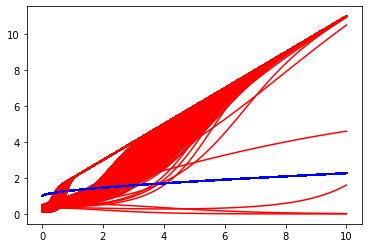

In [6]:
# initial theta 
N = 1000
theta = [0,0,0,0.1]
# gradient ascend step size 
alpha = 0.001
# store theta
THETA3 = np.zeros((len(theta)-1,N))
for i in range(N):
    if i%100 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA3[:,i] = theta[:len(theta)-1]
    plot3(theta)

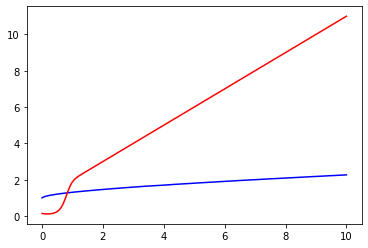

In [7]:
plot3(theta)

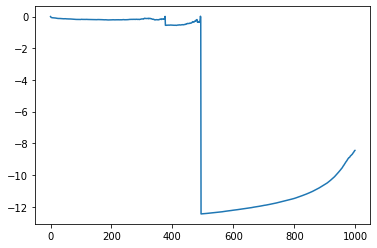

In [8]:
plt.plot(THETA3[0,:])

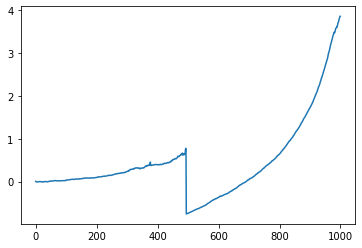

In [9]:
plt.plot(THETA3[1,:])

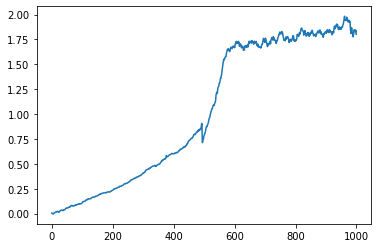

In [10]:
plt.plot(THETA3[2,:])

### policy gradient
Assume the policy form $\theta = (a,b,c,d, \sigma = 0.1)$, then $\pi_\theta$ ~ $N(\frac{1}{1+e^{a w^3 +b w^2 + c w + d}}, \sigma)$

Assume the initial value $a = 0$, $b = 0$, $c = 0$, $d = 0$, $\sigma = 0.1$     


$$\theta_{k+1} = \theta_{k} + \alpha  \nabla_\theta V(\pi_\theta)|\theta_k$$

In [11]:
T = 100
# simulation step T = 20
def poly(theta, w):
    return theta[0] * w + theta[1]

def mu(theta, w):
    return 1 / (1+np.exp(poly(theta, w)))

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.uniform(w_low, w_high)
    for t in range(T):
        n = np.random.normal(mu(theta, w), theta[-1])
        n = max(min(n, 1-eps), eps)
        c = (w+y) * n
        wPath[t] = w
        aPath[t] = n
        rPath[t] = u(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath



def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            newGrad[0] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(wp))
            newGrad[1] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(1)) 
            grad += newGrad * np.sum(rp)
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 

def plot3(theta):
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, mu(theta,ws)*(ws+1), 'r')

0
[0, 0, 0.1]
100
[-0.2028288   0.05913833  0.1       ]
200
[-0.43083218  0.05301624  0.1       ]
300
[-0.48504625  0.14457437  0.1       ]
400
[-0.55104897  0.20232311  0.1       ]
500
[-0.5862338   0.28310377  0.1       ]
600
[-0.64356402  0.32188588  0.1       ]
700
[-0.66414905  0.40832839  0.1       ]
800
[-0.70107238  0.4678659   0.1       ]
900
[-0.70063956  0.56608315  0.1       ]


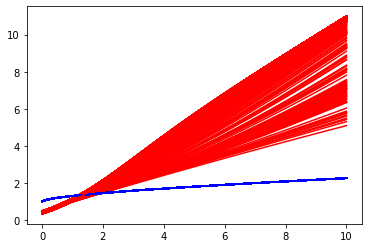

In [12]:
# initial theta 
N = 1000
theta = [0,0,0.1]
# gradient ascend step size 
alpha = 0.001
# store theta 
THETA3 = np.zeros((len(theta)-1,N))
for i in range(N):
    if i%100 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA3[:,i] = theta[:len(theta)-1]
    plot3(theta)

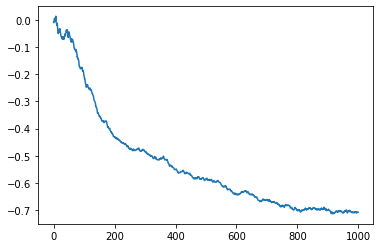

In [13]:
plt.plot(THETA3[0,:])

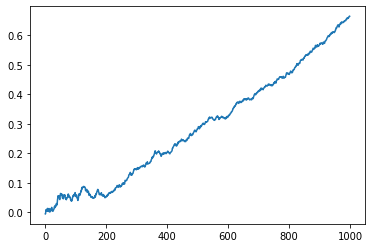

In [14]:
plt.plot(THETA3[1,:])

In [15]:
T = 100
# simulation step T = 100
def poly(theta, w):
    return theta[0] * (w**3) + theta[1] * (w**2) + theta[2] * w + theta[3]

def mu(theta, w):
    return 1 / (1+np.exp(poly(theta, w)))

def simSinglePath(theta):
    wPath = np.zeros(T)
    aPath = np.zeros(T)
    rPath = np.zeros(T)
    w = np.random.uniform(w_low, w_high)
    for t in range(T):
        n = np.random.normal(mu(theta, w), theta[-1])
        n = max(min(n, 1-eps), eps)
        c = (w+y) * n
        wPath[t] = w
        aPath[t] = n
        rPath[t] = u(c)*(beta**t)
        if np.random.uniform(0,1) > 0.5:
            w = (w+y-c) * (1+r_up)
        else:
            w = (w+y-c) * (1-r_down)
    return wPath, aPath, rPath



def gradientV(theta, D = 100):
    '''
        D is the sample size
    '''
    notValid = True
    while notValid:
        grad = np.zeros(len(theta))
        newGrad = np.zeros(len(theta))
        for d in range(D):
            wp, ap, rp = simSinglePath(theta)
            newGrad[0] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(wp**3))
            newGrad[1] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(wp**2))
            newGrad[2] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(wp)) 
            newGrad[3] = np.sum((ap - mu(theta, wp))/(theta[-1]**2)*(mu(theta,wp)**2*np.exp(poly(theta, wp)))*(1)) 
            grad += newGrad * np.sum(rp)
        grad /= D
        if numpy.isnan(grad).any() == False:
            notValid = False
    return grad

def updateTheta(theta):
    theta = theta + alpha * gradientV(theta)
    return theta 

def plot3(theta):
    plt.plot(ws, Cs, 'b')
    plt.plot(ws, mu(theta,ws)*(ws+1), 'r')

In [ ]:
# initial theta 
N = 1000
theta = [0,0,0,0,0.1]
# gradient ascend step size 
alpha = 0.001
# store theta 
THETA3 = np.zeros((len(theta)-1,N))
for i in range(N):
    if i%100 ==0:
        print(i)
        print(theta)
    theta = updateTheta(theta)
    THETA3[:,i] = theta[:len(theta)-1]
    plot3(theta)

0
[0, 0, 0, 0, 0.1]
100
[-0.3563879   0.00083514  0.07223417  0.14009326  0.1       ]
200
[-0.33222385  0.05872787  0.16333362  0.28351188  0.1       ]
300
[-0.25547587  0.17520214  0.30219279  0.45403216  0.1       ]


In [ ]:
plt.plot(THETA3[0,:])

In [ ]:
plt.plot(THETA3[1,:])

In [ ]:
plt.plot(THETA3[2,:])

In [ ]:
plt.plot(THETA3[3,:])